In [1]:
# all imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K

from PIL import Image
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau


In [2]:
# it was decided to split training images into smaller patches due to OOM error when training the first models
# because of function implementation PATCH_SIZE should be a divider of the original image size
PATCH_SIZE = 768
# PATCH_SIZE = 384
# PATCH_SIZE = 256

In [3]:
# aka env variables
BASE_DIR = './airbus-ship-detection'
TEST_IMG_DIR = os.path.join(BASE_DIR,'test_v2')
TRAIN_IMG_DIR = os.path.join(BASE_DIR,'train_v2')
TRAIN_DATASET_CSV = os.path.join(BASE_DIR,'train_ship_segmentations_v2.csv')

In [4]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)

# add info about ship beeing present in the image
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)
print(f"{df.sample()}")
# add info about total number of ships at the image
df['ship_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# concat all EncodedPixels into AllEncodedPixels
df['AllEncodedPixels'] = df.groupby('ImageId')['EncodedPixels'].transform(
    lambda x: np.nan if x.isna().all() else ' '.join(filter(None, x))
)

# remove repeating images
df = df.drop_duplicates(subset='ImageId', keep='first')

# delete EncodedPixels column
df = df.drop(columns=['EncodedPixels'])

# reset indexes
df = df.reset_index(drop=True)


df.head()


              ImageId EncodedPixels  has_ship
116850  80daef961.jpg           NaN         0


,ImageId,has_ship,ship_count,AllEncodedPixels
0,00003e153.jpg,0,0,NaN
1,0001124c7.jpg,0,0,NaN
2,000155de5.jpg,1,1,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,1,5,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,0,0,NaN


In [5]:
# # check the results of the previous operations

# tst = df[df['ImageId'] == '000194a2d.jpg']['AllEncodedPixels'].tolist()
# print(tst)

C:\Users\me\AppData\Local\Temp\ipykernel_38076\2293522108.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ship_count', data=df, palette='viridis')


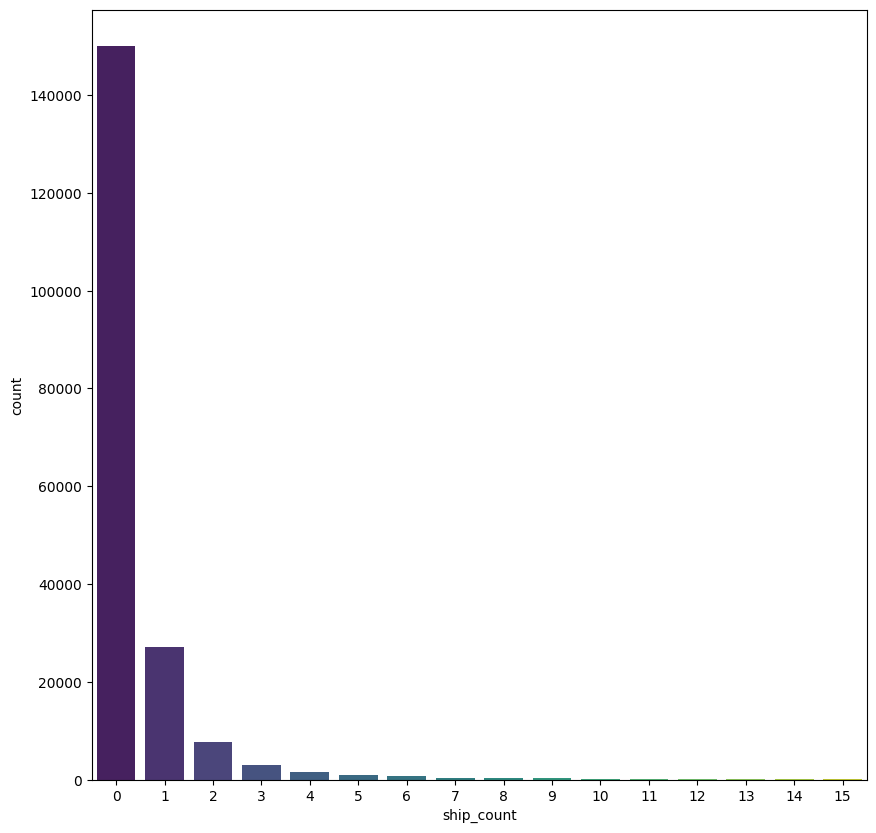

In [6]:
# check distribution of ship_count per image
plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=df, palette='viridis')
plt.show()

In [7]:

value_counts = df['ship_count'].value_counts()
print(value_counts)


ship_count
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64


C:\Users\me\AppData\Local\Temp\ipykernel_38076\897665859.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ship_count', data=balanced_df, palette='viridis')


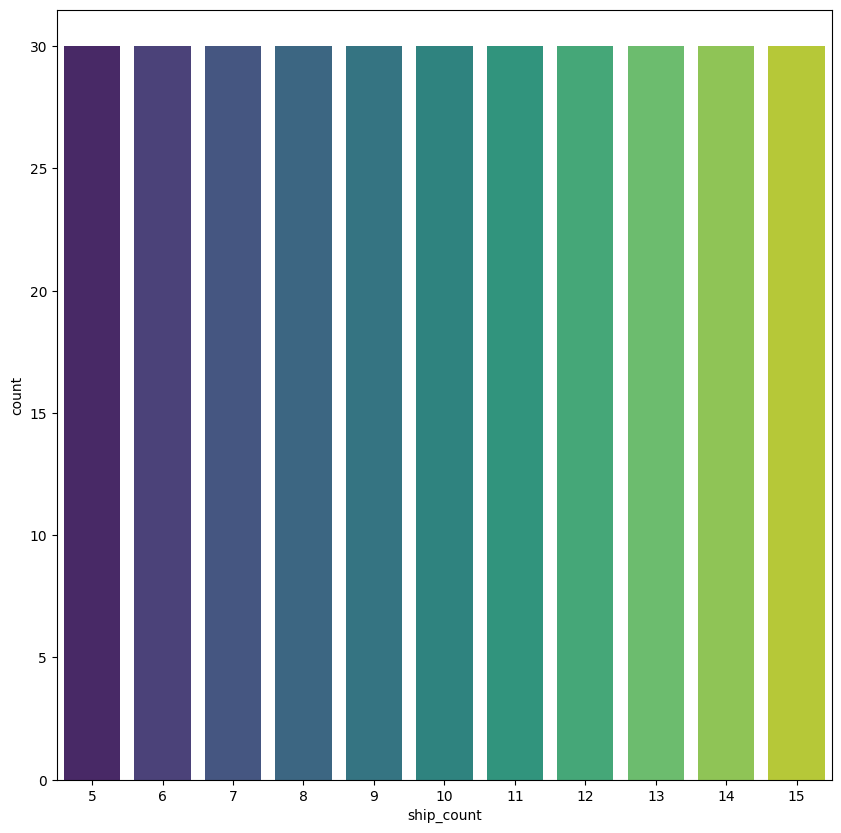

In [8]:
# balance dataset
NUM_SAMPLES = 30
# NUM_SAMPLES = value_counts.min()

balanced_df = pd.DataFrame()

for value in value_counts.index:
    subset = df[df['ship_count'] == value]
    number_samples = NUM_SAMPLES if NUM_SAMPLES < len(subset) else len(subset)
    resampled_subset = resample(subset, replace=False, n_samples=number_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, resampled_subset])

# drop images with less than 10 ships

balanced_df = balanced_df[balanced_df['ship_count'] >= 5]

    
plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=balanced_df, palette='viridis')
plt.show()


In [9]:
# split train data into train and validation
train_ids, validation_ids = train_test_split(
    balanced_df, test_size = 0.1, stratify = balanced_df['ship_count'])

train_df = pd.merge(balanced_df, train_ids)
validation_df = pd.merge(balanced_df, validation_ids)

print(f"train_df:\n {train_df.sample(5)}")
print(f"validation_df:\n {validation_df.sample(5)}")

train_df:
            ImageId  has_ship  ship_count  \
130  209631ac6.jpg         1           9   
118  31dec9d35.jpg         1           9   
207  ac30898c3.jpg         1          12   
178  7b992de0c.jpg         1          11   
173  87e93f8fc.jpg         1          11   

                                      AllEncodedPixels  
130  86229 11 86999 9 87770 6 88538 6 89306 6 90073...  
118  349141 1 349908 3 350675 5 351442 6 352209 8 3...  
207  409190 1 409958 2 410726 2 411493 2 412261 2 4...  
178  106087 2 106853 5 107619 7 108386 9 109155 8 1...  
173  400564 2 401329 5 402095 8 402863 8 403632 8 4...  
validation_df:
           ImageId  has_ship  ship_count  \
31  55e23a0ba.jpg         1          15   
7   1e9238eb9.jpg         1           7   
32  4fde25a38.jpg         1          15   
19  658bf62a0.jpg         1          11   
25  f05bc5755.jpg         1          14   

                                     AllEncodedPixels  
31  347476 2 348243 5 349011 7 349778 10 350546 12.

In [10]:
print(balanced_df.shape[0])
print(train_df.shape[0])


330
297


In [11]:
#utility functions
def rle_to_mask(starts, lengths, height, width):
    # Create an empty array of zeros of shape (height, width)
    mask = np.zeros(height * width, dtype=np.uint8)
    
    # For each start and length, set the corresponding values in the mask to 1
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    
    # Reshape the mask into the desired dimensions
    mask = mask.reshape((height, width))
    mask = mask.T
    return mask

def create_mask(mask_array, width=768, height=768):
    masks = np.zeros((width, height), dtype=np.int16)
    # if element == element:
    if isinstance(mask_array, str):
        split = mask_array.split()
        # print(split)
        startP, lengthP = [np.array(x, dtype=int) for x in (split[::2], split[1::2])]
        masks += (rle_to_mask(startP, lengthP, width, height))
    return masks

In [12]:
# image generator

# for resizing
from skimage import io, transform
from skimage.transform import rescale, resize, downscale_local_mean

BATCH_SIZE = 8

def img_gen(input_df, batch_size = BATCH_SIZE, patch_size = PATCH_SIZE):
    # shuffle the dataset
    input_df = input_df.sample(frac=1, random_state=42).reset_index(drop=True)
    out_rgb = []
    out_mask = []
    while True:
        for index, row in input_df.iterrows():
            rgb_path = os.path.join(TRAIN_IMG_DIR, row.ImageId)
            rgb = Image.open(rgb_path)
            rgb = np.array(rgb)/255.0
            rgb = transform.resize(rgb, (patch_size, patch_size), anti_aliasing=True)

#             mask = create_mask_256_256(row.AllEncodedPixels)

            mask = create_mask(row.AllEncodedPixels)
            mask = transform.resize(mask, (patch_size, patch_size), anti_aliasing=True)
#             the next line is 'kostyl' to address min/max mask values beeing equal to 0.0/3.051851e-05
            mask = np.where(mask > 0, 1, 0)
            mask = np.expand_dims(mask, -1)
            
            # code for generating patches
            patch_number = 1
            for i in range(0, rgb.shape[0], patch_size):
                for j in range(0, rgb.shape[1], patch_size):
                    single_mask_patch = mask[i:i+patch_size, j:j+patch_size]
                    if (single_mask_patch.max()):
                        single_rgb_patch = rgb[i:i+patch_size, j:j+patch_size]
                        out_rgb += [single_rgb_patch]
                        out_mask += [single_mask_patch]
                    patch_number += 1
                    if len(out_rgb)>=batch_size:
                        yield np.stack(out_rgb, 0), np.stack(out_mask, 0).astype(np.float32)
                        out_rgb, out_mask=[], []

#             out_rgb += [rgb]
#             out_mask += [mask]
#             if len(out_rgb)>=batch_size:
#                 yield np.stack(out_rgb, 0), np.stack(out_mask, 0).astype(np.float32)
#                 out_rgb, out_mask=[], []



In [13]:
train_gen = img_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

# check resizing
# TODO
# why after resizing min/max of y = 0.0/3.051851e-05 ???
# plt.imshow(train_x[0])
# plt.show()
# plt.imshow(train_y[0])
# plt.show()

# for i in range(BATCH_SIZE):
#     plt.imshow(train_x[i])
#     plt.show()
#     plt.imshow(train_y[i])
#     plt.show()


x (8, 768, 768, 3) 0.0 1.0
y (8, 768, 768, 1) 0.0 1.0


In [14]:
# chk_x = train_x[0]
# chk_y = train_y[0]
# print('x', chk_x.shape, chk_x.min(), chk_x.max())
# print('y', chk_y.shape, chk_y.min(), chk_y.max())
# plt.imshow(chk_x)
# plt.show()
# plt.imshow(chk_y)
# plt.show()
# chk_x = transform.resize(chk_x, (256,256))
# chk_y = transform.resize(chk_y, (256,256))
# chk_y = np.where(chk_y > 0.1, 1, 0)

# # chk_x = chk_x[::3, ::3]
# # chk_y = transform.rescale(chk_y, 1/3)
# print('x', chk_x.shape, chk_x.min(), chk_x.max())
# print('y', chk_y.shape, chk_y.min(), chk_y.max())
# plt.imshow(chk_x)
# plt.show()
# plt.imshow(chk_y)
# plt.show()


In [15]:
# print(validation_x)

In [16]:
# data augmentation

# arhuments for augmentation image generator
data_gen_args = dict(rotation_range = 90,
                       horizontal_flip = True,
                       vertical_flip = True,
                       data_format = 'channels_last')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def augmentation_generator(input_gen, seed = None):
    random_seed = np.random.randint(0, 10000)
    for input_x, input_y in input_gen:
        augmented_x = image_datagen.flow(
            input_x*255,
            batch_size=input_x.shape[0],
            seed=random_seed
        )

        augmented_y = mask_datagen.flow(
            input_y,
            batch_size=input_y.shape[0],
            seed=random_seed
        )

        yield next(augmented_x)/255.0, next(augmented_y)


In [17]:
# model_fit_gen = augmentation_generator(train_gen)

# train_gen = augmentation_generator(train_gen)
# t_x, t_y = next(model_fit_gen)
# print('x', t_x[0].shape, t_x.dtype, t_x.min(), t_x.max())
# print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

In [18]:
# model

GAUSSIAN_NOISE = 0.1

def unet(input_shape, optimizer, loss, metrics):
    inputs = Input(input_shape)
    inputs = layers.GaussianNoise(GAUSSIAN_NOISE)(inputs)
    inputs = layers.BatchNormalization()(inputs)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = layers.Dropout(0.1) (c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = layers.MaxPooling2D((2, 2)) (c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = layers.Dropout(0.1) (c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = layers.MaxPooling2D((2, 2)) (c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = layers.Dropout(0.1) (c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = layers.Dropout(0.1) (c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = layers.MaxPooling2D((2, 2)) (c4)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = layers.Dropout(0.1) (c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = layers.Dropout(0.1) (c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = layers.Dropout(0.1) (c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = layers.Dropout(0.1) (c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = layers.Dropout(0.1) (c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


In [19]:
# loss functions
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3]  )
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)


def dice_loss(y_true, y_pred):
    return 1 - dice_score(y_true, y_pred)

def bce_loss(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=[1, 2, 3])

def dice_bce_loss(y_true, y_pred):
    dice_loss_value = dice_loss(y_true, y_pred)
    bce_loss_value = bce_loss(y_true, y_pred)
    return dice_loss_value + bce_loss_value

In [20]:
# callbacks


tensorboard = TensorBoard(log_dir='logs')

earlystopping = EarlyStopping(
    monitor="val_dice_score", 
    mode="max", 
    patience=15) 

checkpoint = ModelCheckpoint(
    filepath='model.{epoch:02d}-{val_loss:.2f}.weights.h5',
    monitor='val_dice_score',
    verbose=1,
    mode='max',
    save_weights_only = True)

reduceLR = ReduceLROnPlateau(
    monitor='val_dice_score',
    factor=0.2, 
    patience=3, 
    verbose=1,
    mode='max',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-6)


callbacks = [tensorboard, earlystopping, checkpoint, reduceLR]

In [21]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
PATCH_SIZE = 768
BATCH_SIZE = 8
NB_EPOCHS = 20

STEP_COUNT = train_df.shape[0]//BATCH_SIZE
INPUT_DATA_DIM = (PATCH_SIZE, PATCH_SIZE, 3)


model_fit_gen = augmentation_generator(img_gen(train_df, BATCH_SIZE, PATCH_SIZE))

# create validation set
# VALIDATION_SET_SIZE = 300
VALIDATION_SET_SIZE = (balanced_df.shape[0] - train_df.shape[0])
validation_x, validation_y = next(img_gen(validation_df, VALIDATION_SET_SIZE, PATCH_SIZE))



print(f"train_df.shape[0] - {train_df.shape[0]}")
print(f"VALIDATION_SET_SIZE - {VALIDATION_SET_SIZE}")
print(f"STEP COUNT - {STEP_COUNT}")

# Open a strategy scope.
with strategy.scope():

    model = unet(INPUT_DATA_DIM, optimizer='adam', loss=dice_bce_loss, metrics=[dice_score])
    model.summary()
    # Train the model on all available devices.
    model.fit(
        model_fit_gen,
        steps_per_epoch=STEP_COUNT,
        epochs=NB_EPOCHS,
        validation_data=(validation_x, validation_y),
        callbacks=callbacks)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
train_df.shape[0] - 297
VALIDATION_SET_SIZE - 33
STEP COUNT - 37
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 768, 768, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 drop

In [ ]:
# def gen_predictions(test_data_path, model, num_predictions):
    